# Flat Price Classification

## Raw data

In [2]:
import pandas as pd

df_raw = pd.read_csv('train_data.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SalePrice                  4124 non-null   int64  
 1   YearBuilt                  4124 non-null   int64  
 2   Size(sqf)                  4124 non-null   int64  
 3   Floor                      4124 non-null   int64  
 4   HallwayType                4124 non-null   object 
 5   HeatingType                4124 non-null   object 
 6   AptManageType              4124 non-null   object 
 7   N_Parkinglot(Ground)       4124 non-null   float64
 8   N_Parkinglot(Basement)     4124 non-null   float64
 9   TimeToBusStop              4124 non-null   object 
 10  TimeToSubway               4124 non-null   object 
 11  N_manager                  4124 non-null   float64
 12  N_elevators                4124 non-null   float64
 13  SubwayStation              4124 non-null   objec

In [3]:
df_raw.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


In [4]:
df_raw.isnull().sum()

,0
SalePrice,0
YearBuilt,0
Size(sqf),0
Floor,0
HallwayType,0
HeatingType,0
AptManageType,0
N_Parkinglot(Ground),0
N_Parkinglot(Basement),0
TimeToBusStop,0


## Data preprocessing

In [5]:
X = df_raw.drop(columns=['SalePrice'])
X.columns = X.columns.str.strip().str.replace(' ', '_')

min_y = df_raw['SalePrice'].min()
max_y = df_raw['SalePrice'].max()

y = pd.cut(df_raw['SalePrice'], bins=[min_y, 100000, 350000, max_y+1], labels=[1, 2, 3], right=False)

In [6]:
X.select_dtypes(include='object').columns

Index(['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
       'TimeToSubway', 'SubwayStation'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42,)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f'{X_train.shape=}')
print(f'{X_val.shape=}')
print(f'{X_test.shape=}')

X_train.shape=(3299, 16)
X_val.shape=(412, 16)
X_test.shape=(413, 16)


In [8]:
print("Unique values:\n")
for column in X_train.select_dtypes(include='object').columns:
    print(f'{column}: {X[column].unique().tolist()}')

Unique values:

HallwayType: ['terraced', 'corridor', 'mixed']
HeatingType: ['individual_heating', 'central_heating']
AptManageType: ['management_in_trust', 'self_management']
TimeToBusStop: ['5min~10min', '0~5min', '10min~15min']
TimeToSubway: ['10min~15min', '5min~10min', '0-5min', '15min~20min', 'no_bus_stop_nearby']
SubwayStation: ['Kyungbuk_uni_hospital', 'Daegu', 'Sin-nam', 'Myung-duk', 'Chil-sung-market', 'Bangoge', 'Banwoldang', 'no_subway_nearby']


In [9]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

one_hot_columns = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
ordinal_columns = ['TimeToBusStop', 'TimeToSubway']
scaler_columns = ['YearBuilt', 'Size(sqf)', 'Floor', 'N_FacilitiesInApt', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager', 'N_elevators', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
transformed_columns = one_hot_columns + ordinal_columns + scaler_columns

column_transformer = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), one_hot_columns),
    ('ordinal', OrdinalEncoder(), ordinal_columns),
    ('scaler', StandardScaler(), scaler_columns)
])



X_train_encoded = column_transformer.fit_transform(X_train[transformed_columns])
X_val_encoded = column_transformer.transform(X_val[transformed_columns])
X_test_encoded = column_transformer.transform(X_test[transformed_columns])

new_column_names = column_transformer.get_feature_names_out(transformed_columns)

X_train = pd.concat([X_train.drop(columns=transformed_columns), pd.DataFrame(X_train_encoded, columns=new_column_names, index=X_train.index)], axis=1)
X_val= pd.concat([X_val.drop(columns=transformed_columns), pd.DataFrame(X_val_encoded, columns=new_column_names, index=X_val.index)], axis=1)
X_test = pd.concat([X_test.drop(columns=transformed_columns), pd.DataFrame(X_test_encoded, columns=new_column_names, index=X_test.index)], axis=1)

In [10]:
X_train.head()

,one_hot__HallwayType_mixed,one_hot__HallwayType_terraced,one_hot__HeatingType_individual_heating,one_hot__AptManageType_self_management,one_hot__SubwayStation_Banwoldang,one_hot__SubwayStation_Chil-sung-market,one_hot__SubwayStation_Daegu,one_hot__SubwayStation_Kyungbuk_uni_hospital,one_hot__SubwayStation_Myung-duk,one_hot__SubwayStation_Sin-nam,...,scaler__YearBuilt,scaler__Size(sqf),scaler__Floor,scaler__N_FacilitiesInApt,scaler__N_Parkinglot(Ground),scaler__N_Parkinglot(Basement),scaler__N_manager,scaler__N_elevators,scaler__N_FacilitiesNearBy(Total),scaler__N_SchoolNearBy(Total)
1327,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231593,-0.114940,0.537564,0.501520,-0.579926,0.546962,-0.098934,-1.434872,0.914579,0.931745
450,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.460309,1.787145,-1.327655,1.782763,-0.891641,1.703003,2.380703,0.642027,-0.255898,-0.200169
3173,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231593,-0.561108,-1.194425,0.501520,-0.579926,0.546962,-0.098934,-1.434872,0.914579,0.931745
2503,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231593,-0.561108,-0.528275,0.501520,-0.579926,0.546962,-0.098934,-1.434872,0.914579,0.931745
1967,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.941207,0.451250,-1.327655,-0.779724,2.425558,-1.407530,0.520975,2.069896,-0.255898,-1.105701


In [11]:
X_train.shape

(3299, 23)

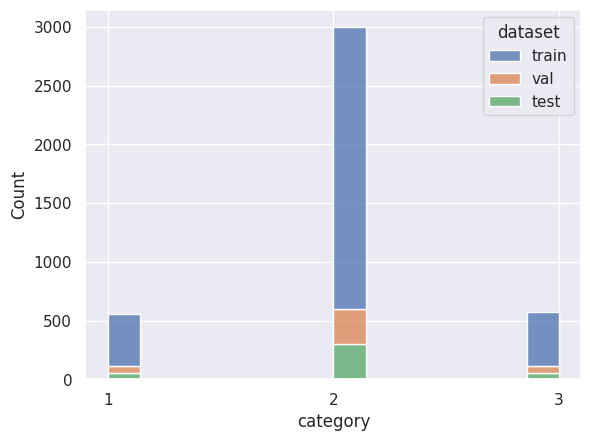

In [12]:
import seaborn as sns
import numpy as np
sns.set()

y_data = pd.DataFrame({
    "category": np.concatenate([y_train, y_val, y_test]),
    "dataset": ["train"] * len(y_train) + ["val"] * len(y_val) + ["test"] * len(y_test)
})

ax = sns.histplot(y_data, x='category', hue='dataset', multiple="stack")
ax.set_xticks([1, 2, 3])

In [13]:
from sklearn.preprocessing import LabelEncoder
y_transformer = LabelEncoder()

y_train

y_train_transformed = y_transformer.fit_transform(y_train)
y_val_transformed = y_transformer.transform(y_val)
y_test_transformed = y_transformer.transform(y_test)

y_train = pd.Series(y_train_transformed, index=y_train.index, name=y_train.name)
y_val = pd.Series(y_val_transformed, index=y_val.index, name=y_val.name)
y_test = pd.Series(y_test_transformed, index=y_test.index, name=y_test.name)

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader(X, y, batch_size=32, shuffle=False):
    X_tensor = torch.FloatTensor(X.values)
    y_tensor = torch.FloatTensor(y.values)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

## Neural Network

In [15]:
import torch.nn as nn

class FlatPriceClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, num_layers, dropout_rate):
        super().__init__()
        layers=[]

        # input layer
        layers.append(nn.Linear(num_inputs, num_hidden))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=dropout_rate))

        # hidden layers
        for _ in range(num_layers-1):
            layers.append(nn.Linear(num_hidden, num_hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))

        # output layer
        layers.append(nn.Linear(num_hidden, num_outputs))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [16]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [35]:
from tqdm import tqdm
import torchmetrics

def evaluate(model, dataloader, device, num_classes, verbose=2):
    model.eval()
    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_f1 = torchmetrics.classification.F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)

    for X, y in tqdm(dataloader, disable=(verbose<2)):
        X, y = X.to(device), y.to(device)

        with torch.inference_mode():
            logits = model(X)

            _, preds = torch.max(logits, dim=1)
            metric_acc(preds, y)
            metric_f1(preds, y)

    return metric_acc.compute(), metric_f1.compute()

In [75]:
from tqdm import tqdm
import torchmetrics

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_classes, num_epochs, verbose=2):
    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_f1 = torchmetrics.classification.F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)

    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()

        for X, y in tqdm(train_dataloader, disable=(verbose<2)):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            logits = model(X)

            loss = criterion(logits, y.long())
            loss.backward()
            optimizer.step()

            _, preds = torch.max(logits, dim=1)
            metric_acc(preds, y)
            metric_f1(preds, y)

        train_accuracy = metric_acc.compute()
        train_f1 = metric_f1.compute()
        metric_acc.reset()
        metric_f1.reset()

        val_accuracy, val_f1 = evaluate(model, val_dataloader, device, num_classes=num_classes, verbose=verbose)

        losses.append(loss.item())
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

        if verbose >= 1:
            print(f'Epoch {epoch}: {loss.item()=:.3f}')
            print(f'\t{train_accuracy=:.3f}, {train_f1=:.3f}')
            print(f'\t{val_accuracy=:.3f}, {val_f1=:.3f}')
            print('')

    return list(range(num_epochs)), losses, train_accuracies, val_accuracies

In [37]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [38]:
print(f'{X_train.shape=}, {y_train.shape=}, {y_train.unique().tolist()=}')

X_train.shape=(3299, 23), y_train.shape=(3299,), y_train.unique().tolist()=[1, 2, 0]


In [39]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight='balanced',
    classes = y_train.unique(),
    y=y_train
)

class_weight

array([0.45857659, 2.41154971, 2.47116105])

In [51]:
batch_size = 64

train_dataloader = create_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataloader = create_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)

In [78]:
classifier = FlatPriceClassifier(num_inputs=23, num_hidden=64, num_outputs=3, num_layers=2, dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weight).to(device))

Epoch 0: loss.item()=0.575
	train_accuracy=0.325, train_f1=0.290
	val_accuracy=0.333, val_f1=0.281

Epoch 1: loss.item()=0.292
	train_accuracy=0.444, train_f1=0.447
	val_accuracy=0.548, val_f1=0.522

Epoch 2: loss.item()=0.183
	train_accuracy=0.541, train_f1=0.527
	val_accuracy=0.575, val_f1=0.537

Epoch 3: loss.item()=0.239
	train_accuracy=0.571, train_f1=0.550
	val_accuracy=0.578, val_f1=0.533

Epoch 4: loss.item()=0.142
	train_accuracy=0.575, train_f1=0.567
	val_accuracy=0.670, val_f1=0.681

Epoch 5: loss.item()=0.270
	train_accuracy=0.608, train_f1=0.620
	val_accuracy=0.671, val_f1=0.696

Epoch 6: loss.item()=0.171
	train_accuracy=0.620, train_f1=0.638
	val_accuracy=0.671, val_f1=0.696

Epoch 7: loss.item()=0.214
	train_accuracy=0.637, train_f1=0.658
	val_accuracy=0.667, val_f1=0.694

Epoch 8: loss.item()=0.214
	train_accuracy=0.645, train_f1=0.674
	val_accuracy=0.634, val_f1=0.649

Epoch 9: loss.item()=0.360
	train_accuracy=0.654, train_f1=0.679
	val_accuracy=0.675, val_f1=0.694



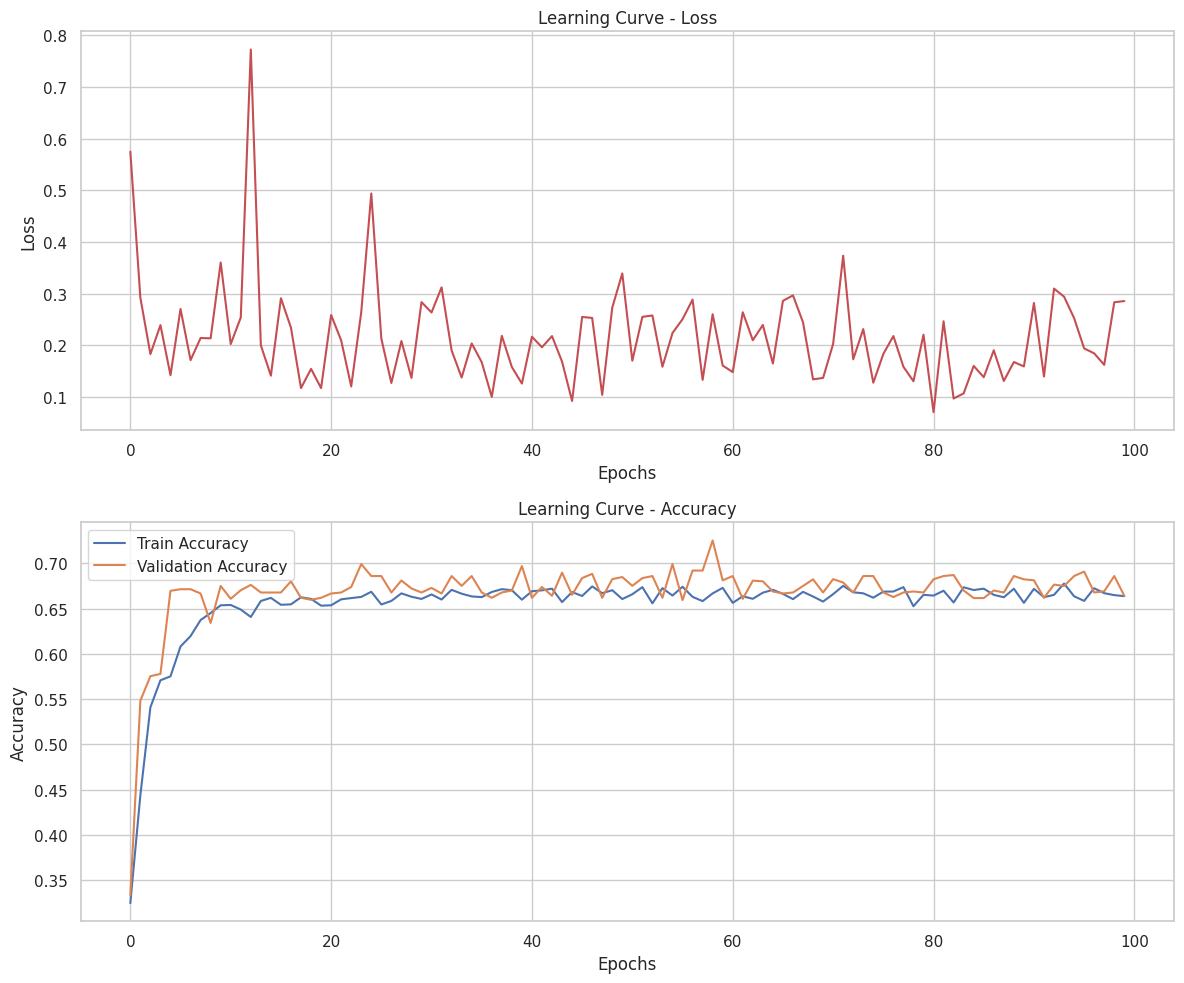

In [79]:
from matplotlib import pyplot as plt
import seaborn as sns

epochs, losses, train_accuracies, val_accuracies = train(classifier, train_dataloader, val_dataloader, criterion, optimizer, device, num_classes=3, num_epochs=100, verbose=1)

sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.lineplot(x=epochs, y=losses, ax=ax1, color='r')
ax1.set_title('Learning Curve - Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

sns.lineplot(x=epochs, y=train_accuracies, ax=ax2, label='Train Accuracy')
sns.lineplot(x=epochs, y=val_accuracies, ax=ax2, label='Validation Accuracy')
ax2.set_title('Learning Curve - Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## Hyperparameter tuning

In [83]:
def test_hyperparameters(num_hidden=64, num_layers=2, dropout_rat=0.1, lr=0.001, weight_decay=0.001, batch_size=64, epochs_num=50):
    pass

In [84]:
hyperparameters_grid = {
    "num_hidden": [32, 64, 128, 256, 512, 1024],
    "num_layers": [1, 2, 3, 4, 5, 6, 7, 8],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
    "lr": [0.1, 0.01, 0.001, 0.0001],
    "weight_decay": [0.1, 0.01, 0.001, 0.0001],
    "batch_size": [32, 64, 128, 256, 512],
    "epochs_num": [50, 100, 200, 500, 1000]
}